In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.features import make_fourier_series_df
from orbit.utils.stan import estimate_level_smoothing

import pystan

In [2]:
df = pd.read_csv('./data/m5_agg_demand.csv', parse_dates=['date'])
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]
df, fs_cols = make_fourier_series_df(df, 'date', period=365, order=3)
df = df[["date", "sales"] + fs_cols]
df['sales'] = np.log(df['sales'])
df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3
0,2011-01-29,10.393018,0.674444,0.738326,0.995919,0.090252,0.796183,-0.605056
1,2011-01-30,10.365617,0.687053,0.726608,0.998435,0.055917,0.763889,-0.645348
2,2011-01-31,10.076726,0.699458,0.714673,0.999769,0.021516,0.729558,-0.683919
3,2011-02-01,10.142977,0.711657,0.702527,0.999917,-0.012910,0.693281,-0.720667
4,2011-02-02,9.859849,0.723644,0.690173,0.998880,-0.047321,0.655156,-0.755493


In [3]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

In [4]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols,
    regressor_sigma_prior=[0.5] * len(fs_cols),
    regression_penalty='lasso',
    period=365,
)

In [5]:
dlt.fit(train_df)
predicted_df = dlt.predict(test_df)

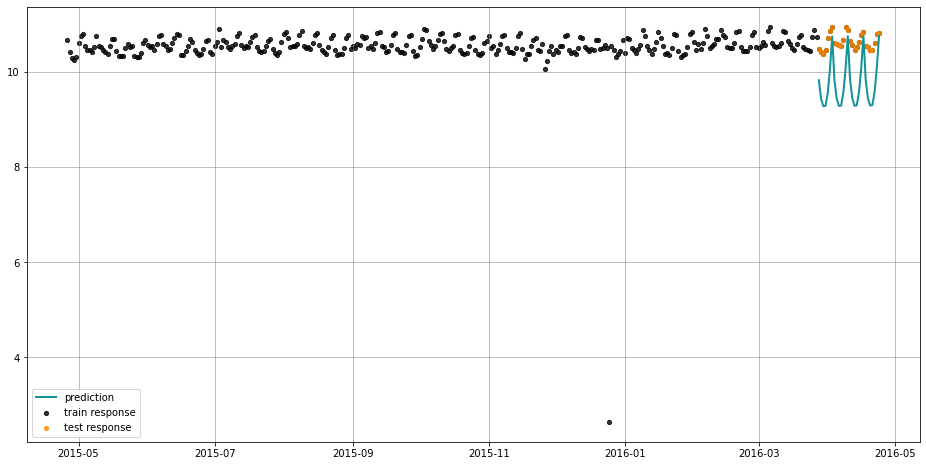

In [6]:
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')

In high frequency data, default DLT yields very bad result mainly due to mixed level smoothing parameters estimation.

In [9]:
dlt._posterior_samples['lev_sm']

array(1.)

In [10]:
derived_lev_sm = estimate_level_smoothing(train_df['sales'].values, horizon=365, n_diff=365)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cb7dc2efcde3830959cf10b98b0ceda NOW.


In [12]:
derived_lev_sm

array(0.00015607)

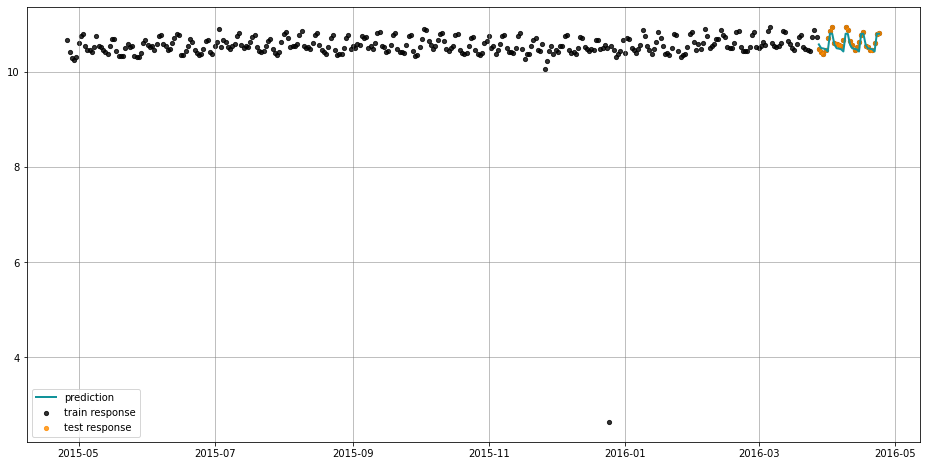

In [14]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    level_sm_input=derived_lev_sm,
    slope_sm_input=derived_lev_sm,
    regressor_col=fs_cols,
    regressor_sigma_prior=[0.5] * len(fs_cols),
    regression_penalty='lasso',
    period=365,
)
dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')

In [217]:
# dlt = DLTMAP(
#     response_col='uFT',
#     date_col='event_week',
#     seasonality=52,
#     seed=2020,
#     level_sm_input=op['lev_sm'], 
#     period=52,
# )
# dlt.fit(train_df)
# predicted_df = dlt.predict(test_df)

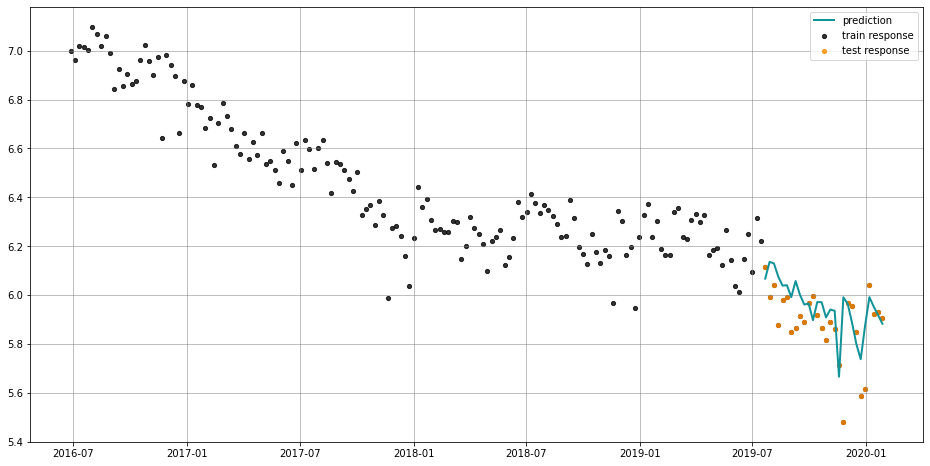

In [218]:
# plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
#                     test_actual_df=test_df, date_col=dlt.date_col,
#                     actual_col='uFT', pred_col='prediction')